<a href="https://colab.research.google.com/github/amirbg4001/BERT-Fake-News-Classifier/blob/main/News_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Installing BERT pretrained with pytorch 
!pip install transformers

     |████████████████████████████████| 4.2 MB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np 
import torch 
from torch import nn
import torchvision
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
plt.style.use('ggplot')


Integreraring Collected Data From kaggle to one DataFrame for further processing

Dataset Used for this project : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download

In [ ]:
# Dataset Reference : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download
# Concating Fake and Real news into one shuffled dataset 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

df_fake = pd.read_csv("Fake.csv").iloc[:5000]
df_real = pd.read_csv("True.csv").iloc[:5000]



df_real["type"] = "Real"
df_fake["type"] ="Fake"

df = pd.concat([df_real,df_fake])
df = df.sample(frac=1 , random_state=59).reset_index()

target = pd.get_dummies(df["type"],drop_first=True)

df = pd.concat([df,target],axis=1)

df.drop(columns=['index','type'],inplace=True)

df.to_csv("Fake_real_news_dataset.csv",index=False)

df.head(1)


,title,text,subject,date,Real
0,Special counsel Mueller asks White House for F...,WASHINGTON (Reuters) - Investigators working f...,politicsNews,"August 5, 2017",1


Buidling Dataset Class using PyTorch capabilities & BERT Tokenizer Immplementation is also included


In [ ]:
# Buidling Dataset Class using PyTorch capabilities & BERT Tokenizer Immplementation is also included
from torch.utils.data import Dataset,DataLoader
class RealFakeNewsDataset(Dataset):
  def __init__(self,df,tokenizer=None,max_length=None) -> None:
      # DataLoading Using Pandas (numpy could be used as well)
      self.df = df
      
      self.target = "Real"
      self.features= 'text'   

      self.y = self.df[self.target]
      self.x = self.df[self.features]

      self.n_samples = df.shape[0]

      # Including Tokenizer
      self.tokenizer=tokenizer
      self.max_length = max_length

  def __getitem__(self, index):
      x = self.x.iloc[index]
      y = self.y.iloc[index]
      sample =  x,y
      # If Tokenizer is passed as an argument in the constructor return tokenized data 
      if self.tokenizer:
        features = self.tokenizer(x,max_length = self.max_length,padding='max_length',return_tensors='pt',truncation=True)
        sample = features , y
      return sample
  def __len__(self):
    return self.n_samples
  

    

Testing if the Dataset class works


In [ ]:
# Testing if the Dataset class works

df=pd.read_csv("Fake_real_news_dataset.csv")

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
data = RealFakeNewsDataset(tokenizer=tokenizer,df=df,max_length=100)

dataloader = DataLoader(dataset=data,batch_size=4,num_workers=3)

dataiter = iter(dataloader)
features,label = dataiter.next()


# decoding one of the records 

decoded = tokenizer.decode(features['input_ids'][0][0])
print(decoded)
print('\n')
print(df['text'].iloc[0])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[CLS] WASHINGTON ( Reuters ) - Investigators working for U. S. special counsel Robert Mueller, who is investigating whether President Donald Trump ’ s 2016 campaign colluded with Russia, have asked the White House for documents related to his former national security adviser Michael Flynn, the New York Times reported on Friday. “ Though not a formal subpoena, the document request is the first known instance of Mr. Mueller ’ s team asking the White [SEP]


WASHINGTON (Reuters) - Investigators working for U.S. special counsel Robert Mueller, who is investigating whether President Donald Trump’s 2016 campaign colluded with Russia, have asked the White House for documents related to his former national security adviser Michael Flynn, the New York Times reported on Friday. “Though not a formal subpoena, the document request is the first known instance of Mr. Mueller’s team asking the White House to hand over records,” said the Times, which cited unnamed people close to the investigation for

Building the Classifier Class using PyTorch 

In [ ]:
from torch.nn.modules.dropout import Dropout
## Classifier model bulding 

class BertFakeNewsDetector(nn.Module):
  def __init__(self,bert_model,dropout=0.2):
      super(BertFakeNewsDetector,self).__init__()

      # Including BertModel for forward section
      self.bert_model = bert_model
      # Using 3 Layer MLP with sigmoid

      layers =[
          nn.Linear(768,512),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(512,128),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(128,1),
          nn.Sigmoid()

      ]
      self.model = nn.Sequential(*layers)
  def forward(self,input_ids,attention_masks):

    _, Bert_output = self.bert_model(input_ids = input_ids , attention_mask = attention_masks , return_dict=False)
    final_output = self.model(Bert_output)
    return final_output

  def real(self,final_output,thereshold=0.5):
    def filt(c):
      if c>= thereshold:
        c = 1
      else :
        c=0
      return c
    
    final_output = final_output.to("cpu")
    final_output = final_output.detach().apply_(filt)
    final_output.require_grad = True 

    return final_output


So Far Required Classes are structured, on the next steps on this project , Bellow task must be done 
1. Checking Data integrity (Class Imbalance , removing data record with less than 100 characters )
2. Spliting Data into training , Validation and Test set
2. Training the Classifier (Fine-tunning)

,title,text,subject,date
Real,,,,
0,5000,5000,5000,5000
1,5000,5000,5000,5000


Classes are well balanced


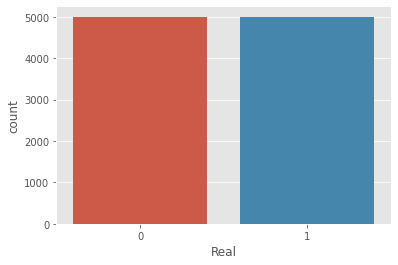

In [ ]:
import seaborn as sns
# Checking Data integrity (Class Imbalance , removing data record with less than 100 characters )

main_df = df=pd.read_csv("Fake_real_news_dataset.csv")

f = main_df['text'].str.len() > 80

main_df = main_df[f]

# Checking Class Imabalance 

main_df.groupby('Real').count()

sns.countplot(x="Real",data=main_df)

print("Classes are well balanced")

In [ ]:
# Spliting Data using Sklearn 

import sklearn
from sklearn.model_selection import train_test_split

#Spliting data set to train , validation and test set 


X_train,X_test,y_train,y_test = train_test_split(main_df['text'],main_df['Real'],random_state=52,test_size=0.4)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=52,test_size=0.5)

train_set = pd.concat([X_train,y_train],axis=1)
val_set = pd.concat([X_val,y_val],axis=1)
test_set = pd.concat([X_test,y_test],axis=1)

#Making instances of Pytorch Dataset for each train , validation and test set to tokenize data 

batch_size=128
max_length=80

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

train_set = RealFakeNewsDataset(tokenizer=tokenizer,df=train_set,max_length=max_length)

val_set = RealFakeNewsDataset(tokenizer=tokenizer,df=val_set,max_length=max_length)

# Dividing datasets to batches for Fine-tuning Section

train_batch = DataLoader(dataset =train_set,batch_size= batch_size )

val_batch = DataLoader(dataset =val_set ,batch_size= batch_size )



So far the Second task which was spliting data into training , validation and test set is complete. On the next section the Fine-Tuning (Training Section) is commenced 

In [ ]:

import torch.optim
import time
start_time = time.time()
# Check if cuda is available 
cuda = torch.cuda.is_available()

if cuda :
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

Bert_model = BertModel.from_pretrained('bert-base-cased')

Classifier = BertFakeNewsDetector(Bert_model,0.5)

learning_rate = 0.002
epochs = 5

optimizer = torch.optim.SGD(Classifier.parameters(),lr=learning_rate)

LossFunc = nn.BCELoss()

total_samples= len(train_set)
n_iter=np.ceil(total_samples/batch_size)

# moving the model on cuda 

if cuda :
  Classifier= Classifier.cuda()
  LossFunc=LossFunc.cuda()

# Starting Fine-Tuning 
train_history ={
    'loss':[],
    "Accuracy":[]
}

val_history ={
    'loss':[],
    "Accuracy":[]
}
for epoch in range(epochs):
  batch_loss_sum =0 
  batch_accuracy_sum= 0 
  #training section (ForEach Batch)
  for i,(features,target) in enumerate(train_batch):

 

    # Reshaping inputs 
    features['input_ids'] = features['input_ids'].view(features['input_ids'].shape[0]*features['input_ids'].shape[1],features['input_ids'].shape[2])
    features['attention_mask'] = features['attention_mask'].view(features['attention_mask'].shape[0]*features['attention_mask'].shape[1],features['attention_mask'].shape[2])

    # Moving Tensors to GPU
    target = target.to(device)
    input_ids = features['input_ids'].to(device)
    attention_mask = features['attention_mask'].to(device)

    #Forward
    outputs = Classifier(input_ids,attention_mask)
    target = target.view(target.shape[0],1)

    # Loss computation for each batch 
    batch_Loss = LossFunc(outputs.float(),target.float())
    batch_loss_sum +=batch_Loss

    # Accuracy computation for each batch 

    predictions = Classifier.real(outputs)
    predictions = predictions.to(device)
    batch_accuracy_sum += (predictions == target).sum().item()


    # Gradient Descent and Backprob
    Classifier.zero_grad()
    batch_Loss.backward()
    optimizer.step()
    


  # Saving Loss value for each epoch
  train_history['loss'].append(batch_loss_sum/len(train_set))
  train_history['Accuracy'].append(batch_accuracy_sum/len(train_set))


  # Validating the training section for each epoch 
  val_loss_sum = 0
  val_accuracy_sum = 0 
  with torch.no_grad():
    for i , (features,target) in enumerate(val_batch):
      
      # Reshaping inputs 
      features['input_ids'] = features['input_ids'].view(features['input_ids'].shape[0]*features['input_ids'].shape[1],features['input_ids'].shape[2])
      features['attention_mask'] = features['attention_mask'].view(features['attention_mask'].shape[0]*features['attention_mask'].shape[1],features['attention_mask'].shape[2])
      # Moving Tensors to GPU
      target = target.to(device)
      input_ids = features['input_ids'].to(device)
      attention_mask = features['attention_mask'].to(device)

      #Forward 
      val_outputs = Classifier(input_ids,attention_mask)
      val_outputs = Classifier.real(val_outputs)
      val_outputs = val_outputs.to(device)
      target = target.view(target.shape[0],1)
    
      # Loss computation for each Validation batch 
      val_loss = LossFunc(val_outputs.float(),target.float())
      val_loss_sum +=val_loss

      # Accuracy computation for each Validation batch 
      val_accuracy_sum += (val_outputs == target).sum().item()

  val_history['loss'].append(val_loss_sum/len(val_set))
  val_history['Accuracy'].append(val_accuracy_sum/len(val_set))
  # Reporting Each epochs' status

  print(f"{epoch+1}/{epochs} Epochs \t Training_loss {train_history['loss'][epoch]:0.5f} \t Training_Accuracy {train_history['Accuracy'][epoch]:0.4f} \t   ")
  print(f"Validation_loss {val_history['loss'][epoch]:0.5f} \t Validation_Accuracy {val_history['Accuracy'][epoch]:0.4f} \t   ")

exec_time = time.time() -  start_time 



print(f'total training and validation time {exec_time/60:0.2f} Mins')

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1/5 Epochs 	 Training_loss 0.00558 	 Training_Accuracy 0.4977 	   
Validation_loss 0.37879 	 Validation_Accuracy 0.5250 	   
2/5 Epochs 	 Training_loss 0.00552 	 Training_Accuracy 0.5397 	   
Validation_loss 0.32857 	 Validation_Accuracy 0.5910 	   
3/5 Epochs 	 Training_loss 0.00540 	 Training_Accuracy 0.6110 	   
Validation_loss 0.25394 	 Validation_Accuracy 0.6827 	   
4/5 Epochs 	 Training_loss 0.00520 	 Training_Accuracy 0.7507 	   
Validation_loss 0.13728 	 Validation_Accuracy 0.8260 	   
5/5 Epochs 	 Training_loss 0.00483 	 Training_Accuracy 0.8913 	   
Validation_loss 0.05022 	 Validation_Accuracy 0.9370 	   
total training and validation time 9.14 Mins


Now our model i Fine-tuned. It is time to evaluate the model with the test set

## **Evaluation Section**

-----------------------------------------------------------

In [ ]:
# Bert_model = BertModel.from_pretrained('bert-base-cased')

# Classifier = BertFakeNewsDetector(Bert_model,0.5)
# cuda = torch.cuda.is_available()

# if cuda :
#   device = torch.device('cuda')
#   Classifier= Classifier.cuda()
# else:
#   device = torch.device('cpu')
# Predicting from test_set
test_set = RealFakeNewsDataset(tokenizer=tokenizer,df=test_set,max_length=max_length)
test_batch = DataLoader(dataset =test_set )
test_targets = torch.empty(y_test.shape[0],1)
test_predictions_proba = torch.empty(y_test.shape[0],1)
test_predictions = torch.empty(y_test.shape[0],1)

for i ,(test_inputs,test_target) in enumerate(test_batch):

      # Reshaping inputs 
      test_inputs['input_ids'] = test_inputs['input_ids'].view(test_inputs['input_ids'].shape[0]*test_inputs['input_ids'].shape[1],test_inputs['input_ids'].shape[2])
      test_inputs['attention_mask'] = test_inputs['attention_mask'].view(test_inputs['attention_mask'].shape[0]*test_inputs['attention_mask'].shape[1],test_inputs['attention_mask'].shape[2])
      # Moving Tensors to GPU
      test_targets[i,0] = test_target[0].item()

      input_ids = test_inputs['input_ids'].to(device)
      attention_mask = test_inputs['attention_mask'].to(device)
      y_prob = Classifier(input_ids,attention_mask)
      y_pred = Classifier.real(y_prob)
      test_predictions_proba[i,0] = y_prob[0].item()
      test_predictions[i,0] = y_pred[0].item()


Validation / Training Accuracy  and  Loss graphs

Text(0, 0.5, 'Accuracy')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0.5, 1.0, 'Training Inspectory Graph')

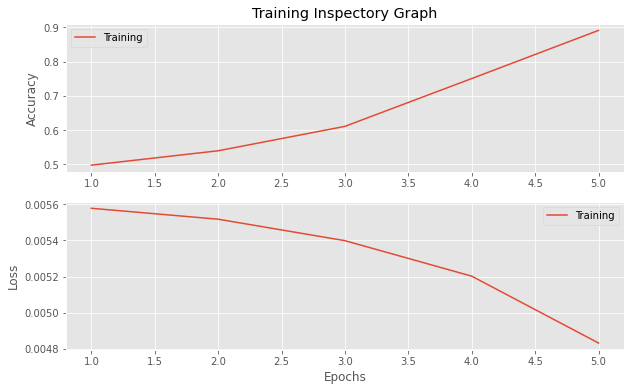

In [ ]:
train_history['loss'] = [ i.item() for i in train_history['loss']]
# train_history['Accuracy'] = [ i.item() for i in train_history['Accuracy']]

val_history['loss'] = [ i.item() for i in val_history['loss']]
# val_history['Accuracy'] = [ i.item() for i in val_history['Accuracy']]

# Training Section 

fig , (ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize=(10,6))
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax1.set_title("Training Inspectory Graph")

ax1.plot(range(1,epochs+1),train_history['Accuracy'],label = "Training")

ax2.plot(range(1,epochs+1),train_history['loss'],label = "Training")


ax1.legend()
ax2.legend()


Text(0, 0.5, 'Accuracy')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0.5, 1.0, 'Validation Inspectory Graph')

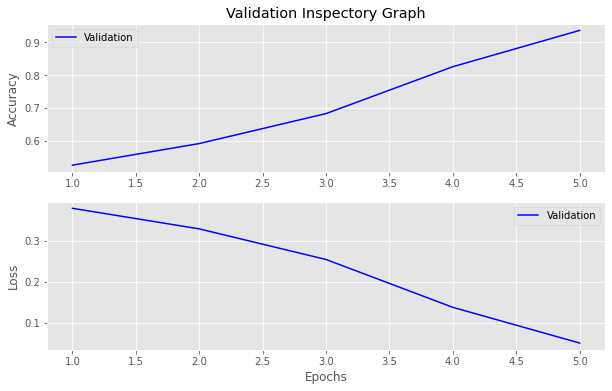

In [ ]:
# Validation Section 

fig , (ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize=(10,6))
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax1.set_title("Validation Inspectory Graph")

ax1.plot(range(1,epochs+1),val_history['Accuracy'],label = "Validation",color='blue')

ax2.plot(range(1,epochs+1),val_history['loss'],label = "Validation",color = "blue")


ax1.legend()
ax2.legend()

ROC Curve and AUC

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC curve')

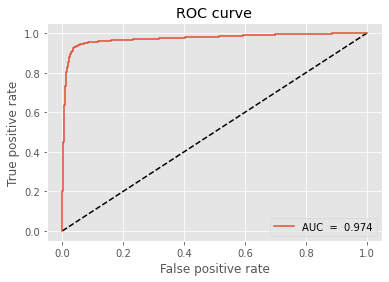

In [ ]:
import sklearn
from sklearn import metrics


fpr,tpr,thershhold = metrics.roc_curve(test_targets,test_predictions_proba)
auc_score = metrics.roc_auc_score(test_targets,test_predictions_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr , label =f'AUC  = {auc_score : 0.3f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()


Confusion Matrix

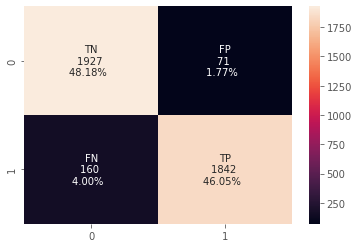

In [ ]:
report = metrics.confusion_matrix(test_targets,test_predictions)

names = ['TN','FP','FN','TP']
counts = [ f"{v:0.0f} " for v in report.flatten()]
percentage = [f"{v:.2%} " for v in report.flatten()/np.sum(report)]

labels = [f"{f1}\n{f2}\n{f3} " for f1,f2,f3 in zip(names,counts,percentage)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(report,annot=labels,fmt='')


Recall / Precision / Accuracy

Text(0.5, 0, 'Precision')

Text(0, 0.5, 'Recall')

Text(0.5, 1.0, 'Binary Precision-Recall Curve')

No handles with labels found to put in legend.


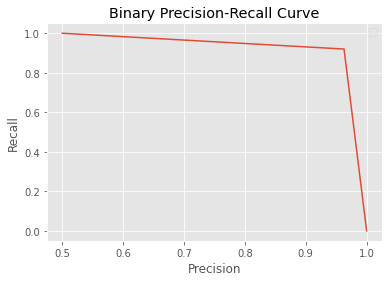

In [ ]:

precision,recall, thershhold = metrics.precision_recall_curve(test_targets , test_predictions)
plt.plot(precision,recall )
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Binary Precision-Recall Curve')
plt.legend()

In [ ]:
accuracy = metrics.accuracy_score(test_targets , test_predictions)
recall_score = metrics.recall_score(test_targets , test_predictions)
precision_score = metrics.precision_score(test_targets , test_predictions)
F1_score = metrics.f1_score(test_targets , test_predictions)
print( f'Accuracy : {accuracy*100 :.2f}%')
print( f'Recall : {recall_score : .2f}')
print( f'Precision : {precision_score:.2f}')
print( f'F1 Score : {F1_score:.2f}')


Accuracy : 94.23%
Recall :  0.92
Precision : 0.96
F1 Score : 0.94
